In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn

In [0]:
transform = transforms.Compose([transforms.ToTensor(), # turn np array into tensor with range 0->1
                                transforms.Normalize( [0.5], [0.5] ) ]) # mean=std=0.5 -> helps converting the range 0-1 into range -1 -> 1 ( reducing cuteness and distortion of the data)
training_dataset = datasets.MNIST(root = './data', train = True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root = './data', train = False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True ) # traning with batch_size =100 and shuffle data b4 tranining to help not getting local minimum
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=True ) # traning with batch_size =100 and shuffle data b4 tranining to help not getting local minimum


In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy() # image in the form (chanel, height, weight) (1, 28, 28)
  image = image.transpose(1, 2, 0)        # image in the form (height, weight, chanel) (28, 28, 1)
  image = image*np.array((0.5 , 0.5, 0.5)) + np.array((0.5 , 0.5, 0.5)) # change into original value of the pixel
  image = image.clip(0, 1)      # ensure the range is 0,1
  return image

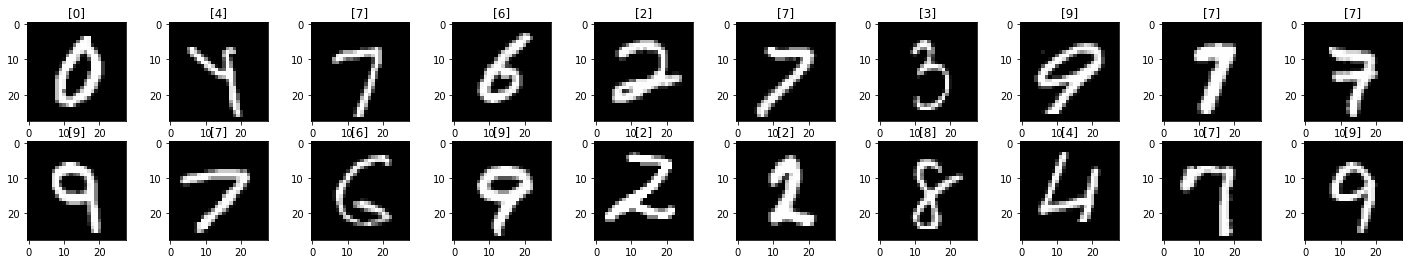

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1) # show img into 2 row 10 cols
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [40]:
images.shape

torch.Size([100, 1, 28, 28])

In [0]:
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out): # nn with 2 hidden layers
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x


In [8]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [17]:
epochs = 10
running_loss_his = []
running_corrects_his = []
val_running_loss_his = []
val_running_corrects_his = []
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss =0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1) # flatten 28x28 -> 784
    outputs = model(inputs)
    loss = criterion(outputs, labels) 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_loss += loss.item()

  else:
    with torch.no_grad(): # bcz this the val set, no need to cal grad() here
      for val_inputs , val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, labels)

      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_his.append(epoch_loss)
    running_corrects_his.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(training_loader)
    val_epoch_acc = val_running_corrects.float()/len(training_loader)
    val_running_loss_his.append(val_epoch_loss)
    val_running_corrects_his.append(val_epoch_acc)

    print('epoch ', e, '   training loss: ', epoch_loss, '      acc: ', epoch_acc)
    print('epoch ', e, '   validation loss: ', epoch_loss, '      acc: ', epoch_acc)

epoch  0    training loss:  0.2679881419738134       acc:  tensor(96.0567)
epoch  0    validation loss:  0.2679881419738134       acc:  tensor(96.0567)
epoch  1    training loss:  0.25261795648684104       acc:  tensor(96.3533)
epoch  1    validation loss:  0.25261795648684104       acc:  tensor(96.3533)
epoch  2    training loss:  0.23796424999212226       acc:  tensor(96.4750)
epoch  2    validation loss:  0.23796424999212226       acc:  tensor(96.4750)
epoch  3    training loss:  0.22359055925160645       acc:  tensor(96.7533)
epoch  3    validation loss:  0.22359055925160645       acc:  tensor(96.7533)
epoch  4    training loss:  0.2104733766677479       acc:  tensor(96.9267)
epoch  4    validation loss:  0.2104733766677479       acc:  tensor(96.9267)
epoch  5    training loss:  0.19992635351295274       acc:  tensor(97.0317)
epoch  5    validation loss:  0.19992635351295274       acc:  tensor(97.0317)
epoch  6    training loss:  0.1893052625997613       acc:  tensor(97.2283)
epoch

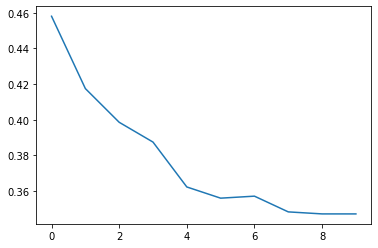

In [49]:
plt.plot(running_loss_his)

In [0]:
# this lr is not so good 
# if the graph is fluctuate, maybe lr is big ( the direction in gradient descent is in a way flip flop back and forth between points over themin and leading to divergent)

In [0]:
# try with new learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

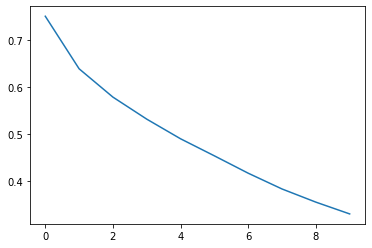

In [12]:
plt.plot(running_loss_his)

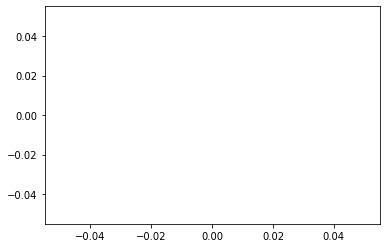

In [53]:
# the res looks better
plt.plot(running_corrects_his)

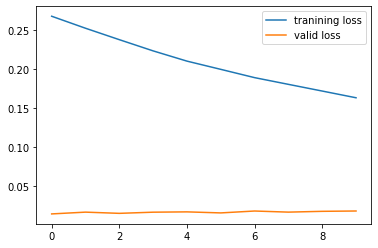

In [18]:
plt.plot(running_loss_his, label='tranining loss')
plt.plot(val_running_loss_his, label='valid loss')
plt.legend()